In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Preprocessing

In [ ]:
import os
import numpy as np
import gc
from tensorflow.keras.utils import to_categorical

# --- Load the NPZ Files ---
train_data = np.load('train-dataset.npz')
X_train = train_data["X"]
y_train = train_data["y"]

valid_data = np.load('valid-dataset.npz')
X_valid = valid_data["X"]
y_valid = valid_data["y"]

test_data = np.load('test-dataset.npz')
X_test = test_data["X"]
y_test = test_data["y"]

# Check current shapes
print("Before transpose:")
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_valid shape:", X_valid.shape, "y_valid shape:", y_valid.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

# The expected shape for Keras (channels-last) is (batch, height, width, channels)
# Your data currently has the shape (batch, 1, height, width), so we need to transpose the axes.
X_train = np.transpose(X_train, (0, 2, 3, 1))
X_valid = np.transpose(X_valid, (0, 2, 3, 1))
X_test  = np.transpose(X_test, (0, 2, 3, 1))

# Check the shapes after transpose
print("After transpose:")
print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)
print("X_test shape:", X_test.shape)

# Calculate the mean and standard deviation from the training data for normalization
mean = np.mean(X_train)
std = np.std(X_train)
print("Normalization parameters: mean =", mean, "std =", std)

# Normalize the data
X_train = (X_train - mean) / std
X_valid = (X_valid - mean) / std
X_test  = (X_test  - mean) / std

gc.collect()


Before transpose:
X_train shape: (8292, 1, 12, 380) y_train shape: (8292, 4)
X_valid shape: (2000, 1, 12, 380) y_valid shape: (2000, 4)
X_test shape: (4764, 1, 12, 380) y_test shape: (4764, 4)
After transpose:
X_train shape: (8292, 12, 380, 1)
X_valid shape: (2000, 12, 380, 1)
X_test shape: (4764, 12, 380, 1)
Normalization parameters: mean = -25.147128970519486 std = 145.0552327372998


8667

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Add, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def res_block(input_tensor, filters, kernel_size=(3,3), strides=(1,1), weight_decay=0.1):
    # Main branch: two Conv2D layers with BatchNormalization and ReLU
    x = Conv2D(filters, kernel_size, padding='same', strides=strides,
               activation='relu', kernel_regularizer=l2(weight_decay))(input_tensor)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, padding='same', strides=(1,1),
               activation=None, kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)

    # Shortcut branch: apply 1x1 convolution if necessary
    shortcut = input_tensor
    if shortcut.shape[-1] != filters or strides != (1,1):
        shortcut = Conv2D(filters, (1,1), strides=strides, padding='same',
                          kernel_regularizer=l2(weight_decay))(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Assume X_train is your training data with shape (num_samples, height, width, 1)
input_shape = (X_train.shape[1], X_train.shape[2], 1)
inputs = Input(shape=input_shape)
num_classes = y_train.shape[1]

# Initial convolution block
x = Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.1))(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

# First Residual Block (64 filters)
x = res_block(x, 64, strides=(1,1), weight_decay=0.1)
x = MaxPooling2D((2,2))(x)

# Second Residual Block (128 filters)
x = res_block(x, 128, strides=(1,1), weight_decay=0.1)
x = MaxPooling2D((2,2))(x)

# Third Residual Block (256 filters)
x = res_block(x, 256, strides=(1,1), weight_decay=0.1)
# Use same padding here to prevent the height from dropping below 1
x = MaxPooling2D((2,2), padding="same")(x)


# Fourth Residual Block (512 filters)
x = res_block(x, 512, strides=(1,1), weight_decay=0.1)
x = MaxPooling2D((2,2), padding="same")(x)  # Using 'same' padding to avoid negative dimensions

# Fully Connected Layers
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.1))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.1))(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.1))(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.1))(x)
x = Dropout(0.4)(x)

# Output Layer
outputs = Dense(num_classes, activation='softmax')(x)

# Create and compile the model
model_resnet = Model(inputs=inputs, outputs=outputs)
model_resnet.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
model_resnet.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 12, 380,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 12, 380,   │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 12, 380,   │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 6, 190,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 6, 190,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 190,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 6, 190,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 6, 190,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 190,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 190,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 6, 190,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 6, 190,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 3, 95, 64) │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 3, 95,     │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 95,     │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 3, 95,     │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 3, 95,     │      8,320 │ max_pooling2d_1[

 Total params: 8,208,068 (31.31 MB)

 Trainable params: 8,202,244 (31.29 MB)

 Non-trainable params: 5,824 (22.75 KB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
history = model_resnet.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=100,
    batch_size=64,
    callbacks=[lr_scheduler]
)


Epoch 1/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 48s 228ms/step - accuracy: 0.6790 - loss: 22.5918 - val_accuracy: 0.4660 - val_loss: 18.0966 - learning_rate: 1.0000e-04
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.6909 - loss: 16.4689 - val_accuracy: 0.4130 - val_loss: 13.7443 - learning_rate: 1.0000e-04
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.7232 - loss: 12.3120 - val_accuracy: 0.3995 - val_loss: 10.7034 - learning_rate: 1.0000e-04
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.7403 - loss: 9.4559 - val_accuracy: 0.5410 - val_loss: 8.2785 - learning_rate: 1.0000e-04
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.7726 - loss: 7.4367 - val_accuracy: 0.4890 - val_loss: 6.8470 - learning_rate: 1.0000e-04
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.7792 - loss: 6.0491 - val_accuracy: 0.5760 - val_loss: 5.6510 - learning_rate: 1.0000e-04
Epoch 7/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 

149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6342 - loss: 1.4358
Final Accuracy on Test Set: 0.7059193849563599
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

      canada       0.70      0.56      0.63      1191
     england       0.57      0.73      0.64      1191
      indian       0.75      0.78      0.76      1191
    scotland       0.85      0.76      0.80      1191

    accuracy                           0.71      4764
   macro avg       0.72      0.71      0.71      4764
weighted avg       0.72      0.71      0.71      4764



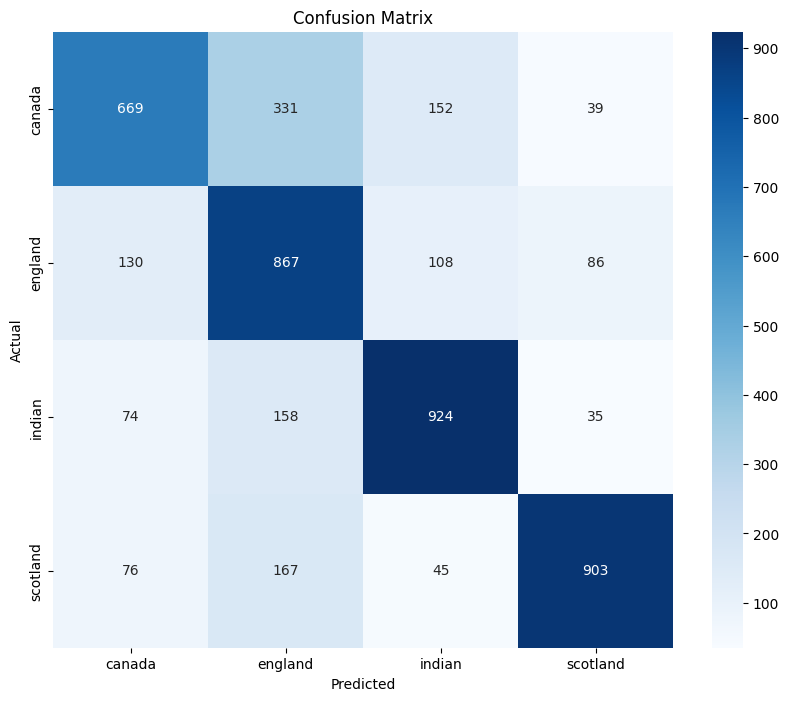

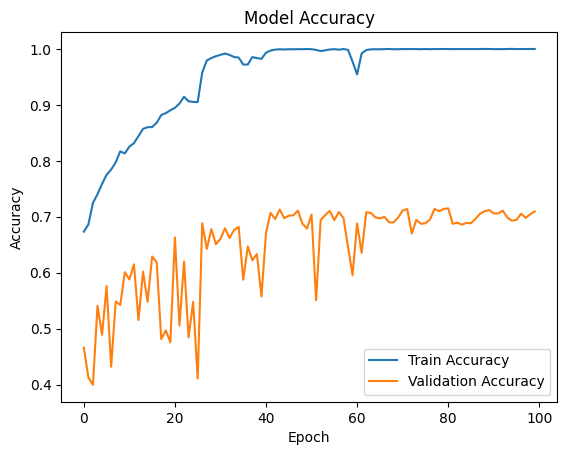

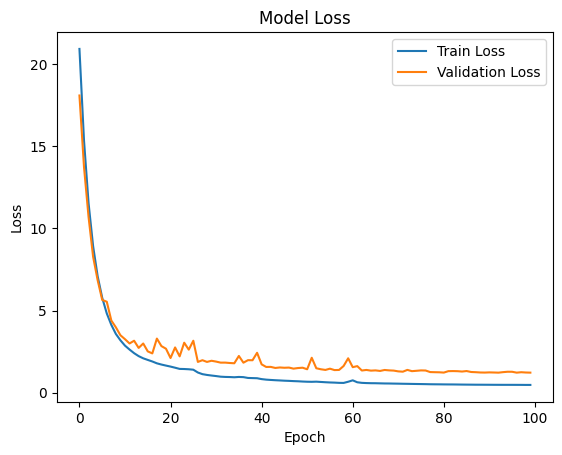

In [ ]:
# Accent label mapping
label_mapping = {0: 'canada', 1: 'england', 2: 'indian', 3: 'scotland'}
target_names = [label_mapping[i] for i in range(len(label_mapping))]

# --- Evaluate the Model on Test Data ---
test_loss, test_accuracy = model_resnet.evaluate(X_test, y_test)
print("Final Accuracy on Test Set:", test_accuracy)

# --- Confusion Matrix and Classification Report ---
y_pred = model_resnet.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print(classification_report(y_true_labels, y_pred_labels, target_names=target_names))
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', dpi=300)  # 파일로 저장
plt.show()

# --- Plot Training History (Accuracy) ---
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()
plt.savefig('model_accuracy.png', dpi=300)  # 파일로 저장
plt.show()

# --- Plot Training History (Loss) ---
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()
plt.savefig('model_loss.png', dpi=300)  # 파일로 저장
plt.show()


In [ ]:
# --- Save the Model ---
model_resnet.save("model_mfcc.h5")

# For environments that support file links (like Kaggle or Jupyter Notebook)
from IPython.display import FileLink
FileLink('model_mfcc.h5')

/content/model_mfcc.h5